# Calculate Statistics of Phase Picks

In [12]:
import h5py
import numpy as np
import pandas as pd

from obspy import read_events
from obspy.core import UTCDateTime
from obspy.geodetics.base import locations2degrees, degrees2kilometers

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['font.size'] = 22


###################### Functions

### Historgram 2x3 for number of picks, SNR and standard deviations
def plot_6hists(npk_raw, npk_mul, snr_raw, snr_mul, std_raw, std_mul, bins=[30,30,30], ranges=[(0,200), (0,200), (0,20), (0,20), (0,2.), (0,2.)]):
    _, ax = plt.subplots(figsize=(18, 12), constrained_layout=True, nrows=2, ncols=3)

    # Define the histogram settings
    hist_settings = [
        {'data': npk_raw[:, 1], 'bins': bins[0], 'color':   'gray', 'alpha': 0.3, 'range': ranges[0], 'xlabel': 'Number of S picks', 'label': 'Picking raw data'},
        {'data': npk_mul[:, 1], 'bins': bins[0], 'edgecolor':'red', 'fill':False, 'range': ranges[0], 'xlabel': 'Number of S picks', 'label': 'Picking denoised data'},
        {'data': npk_raw[:, 0], 'bins': bins[0], 'color':   'gray', 'alpha': 0.3, 'range': ranges[1], 'xlabel': 'Number of P picks'},
        {'data': npk_mul[:, 0], 'bins': bins[0], 'edgecolor':'red', 'fill':False, 'range': ranges[1], 'xlabel': 'Number of P picks'},
        {'data': snr_raw[:, 1], 'bins': bins[1], 'color':   'gray', 'alpha': 0.3, 'range': ranges[2], 'xlabel': 'SNR of S'},
        {'data': snr_mul[:, 1], 'bins': bins[1], 'edgecolor':'red', 'fill':False, 'range': ranges[2], 'xlabel': 'SNR of S'},
        {'data': snr_raw[:, 0], 'bins': bins[1], 'color':   'gray', 'alpha': 0.3, 'range': ranges[3], 'xlabel': 'SNR of P'},
        {'data': snr_mul[:, 0], 'bins': bins[1], 'edgecolor':'red', 'fill':False, 'range': ranges[3], 'xlabel': 'SNR of P'},
        {'data': std_raw[:, 1], 'bins': bins[2], 'color':   'gray', 'alpha': 0.3, 'range': ranges[4], 'xlabel': 'Standard deviation of S time misfit'},
        {'data': std_mul[:, 1], 'bins': bins[2], 'edgecolor':'red', 'fill':False, 'range': ranges[4], 'xlabel': 'Standard deviation of S time misfit'},
        {'data': std_raw[:, 0], 'bins': bins[2], 'color':   'gray', 'alpha': 0.3, 'range': ranges[5], 'xlabel': 'Standard deviation of P time misfit'},
        {'data': std_mul[:, 0], 'bins': bins[2], 'edgecolor':'red', 'fill':False, 'range': ranges[5], 'xlabel': 'Standard deviation of P time misfit'}
    ]

    # Plot the histograms
    for i, settings in enumerate(hist_settings):
        sub_ind = i // 2
        col = sub_ind // 2
        row = sub_ind % 2
    
        ax[row, col].hist(settings['data'], bins=settings['bins'], color=settings.get('color', 'gray'), alpha=settings.get('alpha', 1.0),
                            edgecolor=settings.get('edgecolor', 'none'), fill=settings.get('fill', True), range=settings.get('range', None),
                            label=settings.get('label', None))
        ax[row, col].set_xlabel(settings.get('xlabel', ''), fontsize=22)
    ax[1, 0].set_ylabel('Number of earthquakes', fontsize=22)
    ax[0, 0].set_ylabel('Number of earthquakes', fontsize=22)
    ax[0, 0].legend(fontsize=20)


# Define a function to load data from HDF5 file
def load_data_from_hdf5(file_path):
    with h5py.File(file_path, 'r') as f:
        raw_alldata_picks = f["raw_alldata_picks"][:]
        one_denoise_picks = f["one_denoise_picks"][:]
        mul_denoise_picks = f["mul_denoise_picks"][:] 
        snr_raw = f["raw_alldata_snr"][:] 
        snr_one = f["one_denoise_snr"][:] 
        snr_mul = f["mul_denoise_snr"][:] 
        npk_raw = f["raw_alldata_numpick"][:] 
        npk_one = f["one_denoise_numpick"][:]
        npk_mul = f["mul_denoise_numpick"][:]
        std_raw = f["raw_alldata_pickerr"][:] 
        std_one = f["one_denoise_pickerr"][:]
        std_mul = f["mul_denoise_pickerr"][:]
    
    return raw_alldata_picks, one_denoise_picks, mul_denoise_picks, snr_raw, snr_one, snr_mul, npk_raw, npk_one, npk_mul, std_raw, std_one, std_mul

# 1. Phase picking on 555 earthquakes in 2023 December

## Read the picks and concatenate

In [37]:
# filepaths = ['/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/pick_stats_0_200.hdf5',
#              '/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/pick_stats_200_400.hdf5',
#              '/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/pick_stats_400_555.hdf5']

filepaths = ['/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/pick_stats_0_200_thr010p005s.hdf5',
             '/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/pick_stats_200_400_thr010p005s.hdf5',
             '/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/pick_stats_400_555_thr010p005s.hdf5']

raw_alldata_picks = np.concatenate([f["raw_alldata_picks"][:] for f in map(h5py.File, filepaths)])
one_denoise_picks = np.concatenate([f["one_denoise_picks"][:] for f in map(h5py.File, filepaths)])
mul_denoise_picks = np.concatenate([f["mul_denoise_picks"][:] for f in map(h5py.File, filepaths)])
snr_raw = np.concatenate([f["raw_alldata_snr"][:] for f in map(h5py.File, filepaths)])
snr_one = np.concatenate([f["one_denoise_snr"][:] for f in map(h5py.File, filepaths)])
snr_mul = np.concatenate([f["mul_denoise_snr"][:] for f in map(h5py.File, filepaths)])
npk_raw = np.concatenate([f["raw_alldata_numpick"][:] for f in map(h5py.File, filepaths)])
npk_one = np.concatenate([f["one_denoise_numpick"][:] for f in map(h5py.File, filepaths)])
npk_mul = np.concatenate([f["mul_denoise_numpick"][:] for f in map(h5py.File, filepaths)])
std_raw = np.concatenate([f["raw_alldata_pickerr"][:] for f in map(h5py.File, filepaths)])
std_one = np.concatenate([f["one_denoise_pickerr"][:] for f in map(h5py.File, filepaths)])
std_mul = np.concatenate([f["mul_denoise_pickerr"][:] for f in map(h5py.File, filepaths)])

# Close the files
for f in map(h5py.File, filepaths):
    f.close()

## Histograms

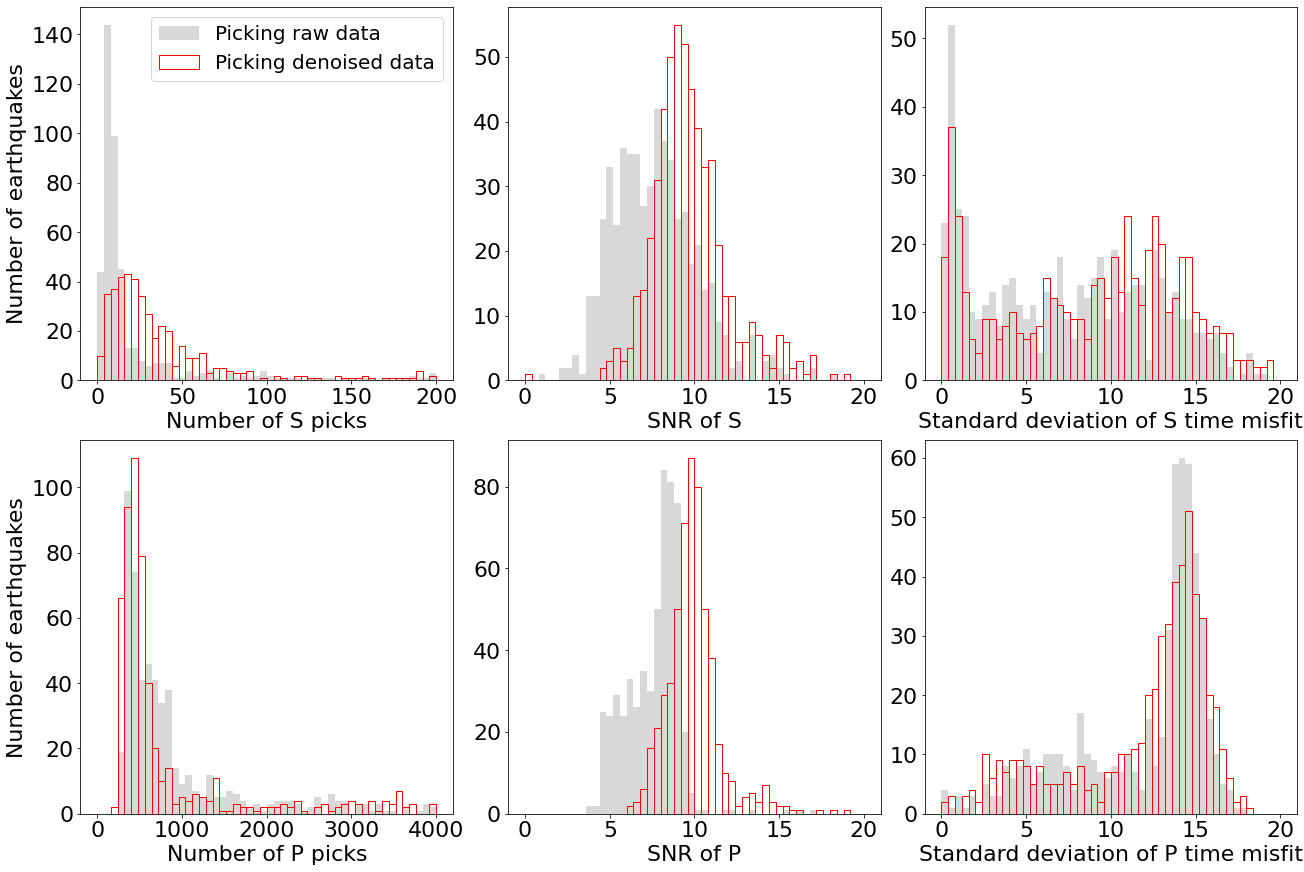

In [11]:
plot_6hists(npk_raw, npk_mul, 20 * np.log10(snr_raw+1e-7), 20 * np.log10(snr_mul+1e-7), std_raw, std_mul, 
            bins=[50,50,50], ranges=[(0,200), (0,4000), (0,20), (0,20), (0,20), (0,20)])

In [38]:
qml = '/fd1/QibinShi_data/akdas/qibin_data/ak_Dec1_31.xml'
cat = read_events(qml)[:len(snr_raw)]

mag = np.zeros(len(cat))
newmag = np.zeros(len(cat))

a, b = -1.2, 0.65
lat0, lon0 = 59.441, -152.028

for i, event in enumerate(cat):
    lon = event.origins[0]['longitude']
    lat = event.origins[0]['latitude']
    dep = event.origins[0]['depth'] * 1e-3
    mag[i] = event.magnitudes[0]['mag']

    distdeg = locations2degrees(lat0, lon0, lat, lon)
    distkm = degrees2kilometers(distdeg)
    rad = np.sqrt(distkm ** 2 + dep ** 2)

    newmag[i] = mag[i] - 10 ** (a + b * np.log10(rad))

## Number of S picks vs magnitudes

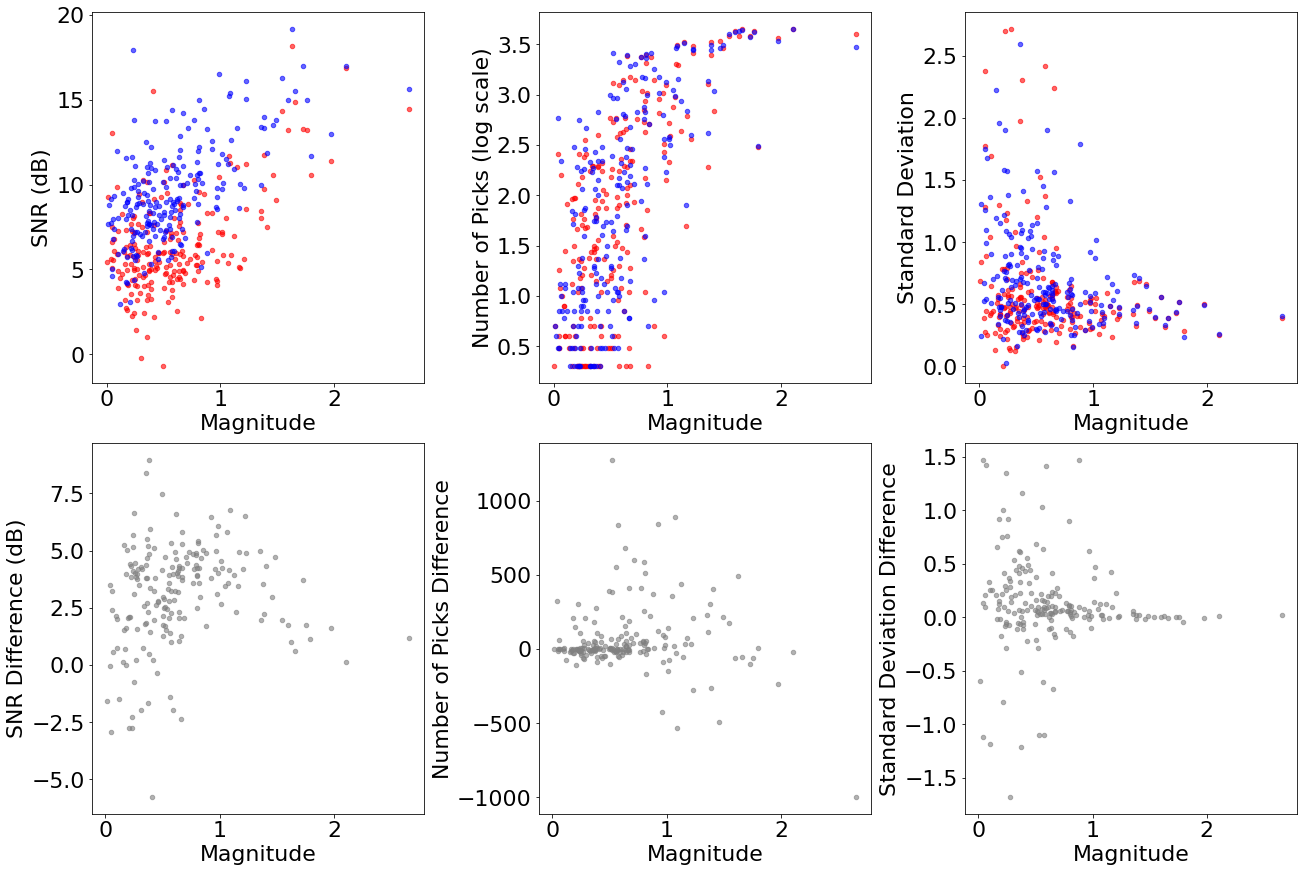

In [39]:
ind1 = np.where(npk_mul[:,1] >1)[0]
ind2 = np.where(npk_raw[:,1] >1)[0]
common_numbers = np.intersect1d(ind1, ind2)

fig, axs = plt.subplots(2, 3, figsize=(18, 12), constrained_layout=True)

# Scatter plot 1
axs[0, 0].scatter(newmag[ind2], 20 * np.log10(snr_raw[ind2,1]), s=20, marker='o', c='red', alpha=0.6)
axs[0, 0].scatter(newmag[ind1], 20 * np.log10(snr_mul[ind1,1]), s=20, marker='o', c='blue', alpha=0.6)
axs[0, 0].set_xlabel('Magnitude')
axs[0, 0].set_ylabel('SNR (dB)')

# Scatter plot 2
axs[0, 1].scatter(newmag[ind2], np.log10(npk_raw[ind2,1]), s=20, marker='o', c='red', alpha=0.6)
axs[0, 1].scatter(newmag[ind1], np.log10(npk_mul[ind1,1]), s=20, marker='o', c='blue', alpha=0.6)
axs[0, 1].set_xlabel('Magnitude')
axs[0, 1].set_ylabel('Number of Picks (log scale)')

# Scatter plot 3
axs[0, 2].scatter(newmag[ind2], std_raw[ind2,1], s=20, marker='o', c='red', alpha=0.6)
axs[0, 2].scatter(newmag[ind1], std_mul[ind1,1], s=20, marker='o', c='blue', alpha=0.6)
axs[0, 2].set_xlabel('Magnitude')
axs[0, 2].set_ylabel('Standard Deviation')

# Scatter plot 4
axs[1, 0].scatter(newmag[common_numbers], 
                  20 * np.log10(snr_mul[common_numbers,1])-20 * np.log10(snr_raw[common_numbers,1]), 
                  s=20, marker='o', c='gray', alpha=0.6)
axs[1, 0].set_xlabel('Magnitude')
axs[1, 0].set_ylabel('SNR Difference (dB)')

# Scatter plot 5
axs[1, 1].scatter(newmag[common_numbers], npk_mul[common_numbers,1]- npk_raw[common_numbers,1], 
                  s=20, marker='o', c='gray', alpha=0.6)
axs[1, 1].set_xlabel('Magnitude')
axs[1, 1].set_ylabel('Number of Picks Difference')

# Scatter plot 6
axs[1, 2].scatter(newmag[common_numbers], std_mul[common_numbers,1]- std_raw[common_numbers,1], 
                  s=20, marker='o', c='gray', alpha=0.6)
axs[1, 2].set_xlabel('Magnitude')
axs[1, 2].set_ylabel('Standard Deviation Difference')

plt.show()


# 2. Phase picking on relatively larger events

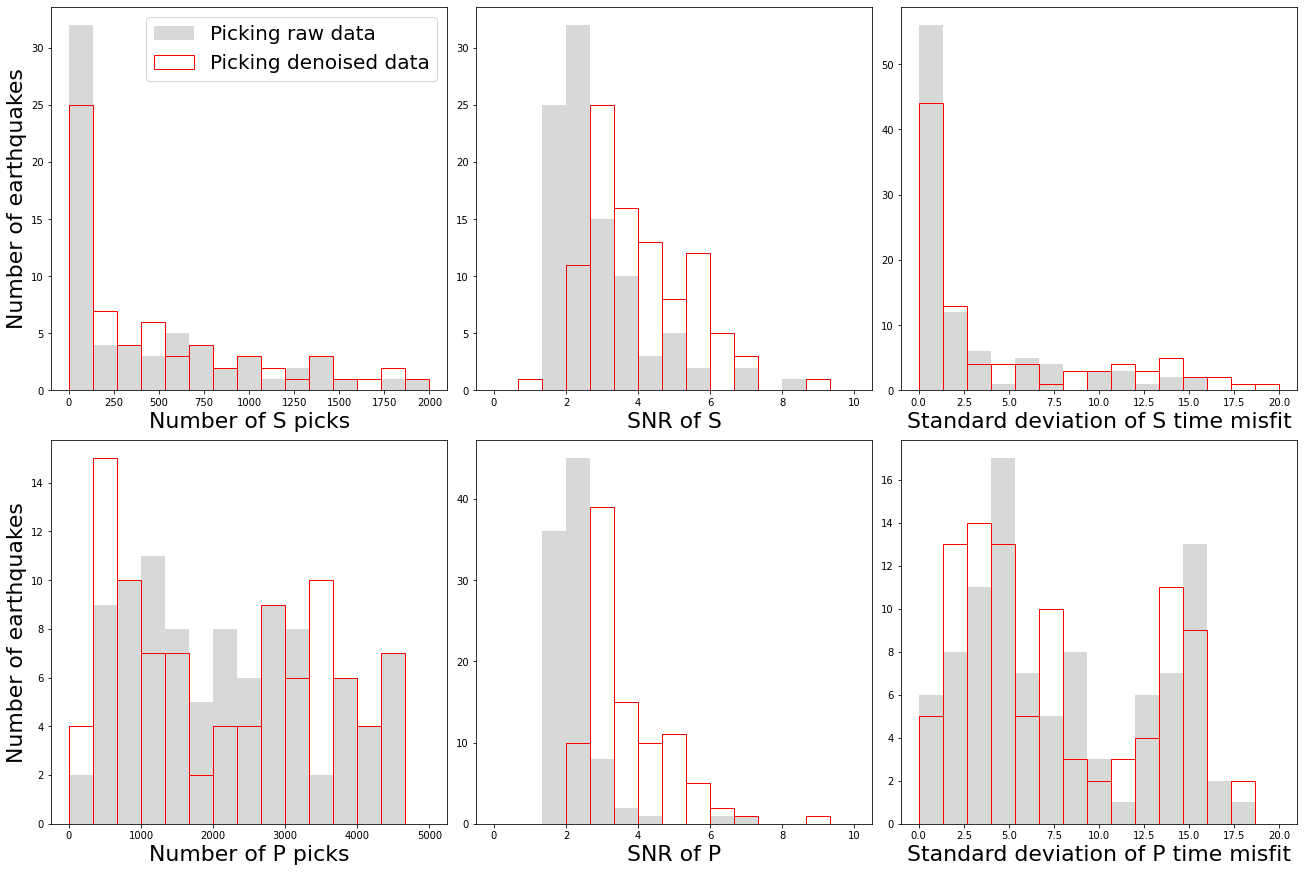

In [3]:
# Call the function to load data from the HDF5 file
file_path = '/fd1/QibinShi_data/akdas/qibin_data/largerEQ_plots_test_picking_dec_ch4500/pick_stats.hdf5'
raw_alldata_picks, one_denoise_picks, mul_denoise_picks, \
    snr_raw, snr_one, snr_mul, npk_raw, npk_one, npk_mul, \
        std_raw, std_one, std_mul = load_data_from_hdf5(file_path)
plot_6hists(npk_raw, npk_mul, snr_raw, snr_mul, std_raw, std_mul, 
bins=[15,15,15], ranges=[(0, 2000), (0, 5000), (0, 10), (0, 10), (0, 20), (0, 20)])

### Read the phase picks to compute errors

In [43]:
# Load phase picks and recording times from HDF5 and CSV files
file_path = "/fd1/QibinShi_data/akdas/qibin_data/largerEQ_plots_test_picking_dec_ch4500/phase_picks.hdf5"
csv_file_path = "/fd1/QibinShi_data/akdas/qibin_data/recording_times_larger.csv"

with h5py.File(file_path, 'r') as h5_file, open(csv_file_path, 'r') as csv_file:
    raw_picks = h5_file["raw_alldata_picks"][:]
    one_picks = h5_file["one_denoise_picks"][:]
    mul_picks = h5_file["mul_denoise_picks"][:]
    pred_picks = h5_file["predicted_picks"][:]

    df = pd.read_csv(csv_file)
    start_times = pd.to_datetime(df['record_time'], format='decimator2_%Y-%m-%d_%H.%M.%S_UTC.h5')

    # Calculate original times for predicted picks
    org_times = [evt.origins[0].time - UTCDateTime(start_t.timestamp()) for evt, start_t in zip(cat, start_times)]
    pred_picks += np.array(org_times)[:, np.newaxis, np.newaxis]


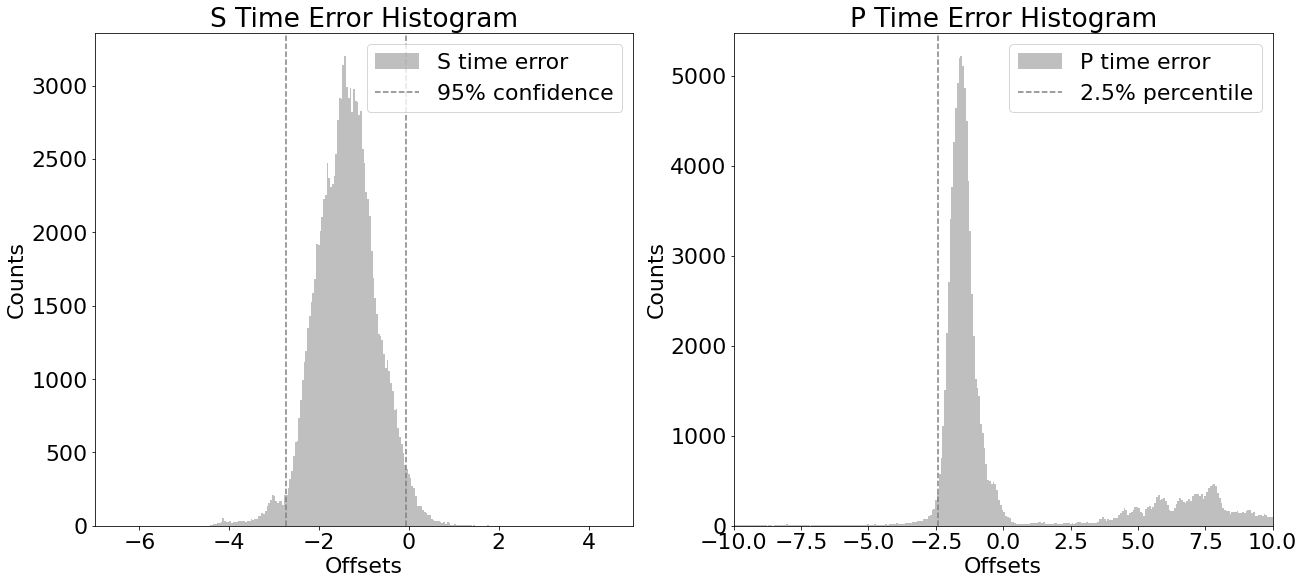

In [44]:
# Flatten the S picks and calculate offsets
s_raw_picks_flat = raw_picks[:,:,1,0].flatten()
s_pred_picks_flat = pred_picks[:,:,1].flatten()
s_pro_flat = raw_picks[:,:,1,1].flatten()
s_ind_flat = np.where(np.logical_and(s_pred_picks_flat < 60, s_pro_flat > 0.05))[0]
s_offsets_raw = s_raw_picks_flat[s_ind_flat] - s_pred_picks_flat[s_ind_flat]
s_ind_narrow = np.where(np.logical_and(s_offsets_raw < 5, s_offsets_raw > -7))[0]

# Flatten the P picks and calculate offsets
p_raw_picks_flat = raw_picks[ind,:,0,0].flatten()
p_pred_picks_flat = pred_picks[ind,:,0].flatten()
p_pro_flat = raw_picks[:,:,0,1].flatten()
p_ind_flat = np.where(np.logical_and(p_pred_picks_flat < 60, p_pro_flat > 0.10))[0]
p_offsets_raw = p_raw_picks_flat[p_ind_flat] - p_pred_picks_flat[p_ind_flat]
p_ind_narrow = np.where(np.logical_and(p_offsets_raw < 10, p_offsets_raw > -10))[0]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), constrained_layout=True)

# Plot the S time error histogram
ax1.hist(s_offsets_raw[s_ind_narrow], bins=300, alpha=0.5, color='gray', label='S time error')
ax1.axvline(np.percentile(s_offsets_raw[s_ind_narrow], 2.5), color='gray', linestyle='--', label='95% confidence')
ax1.axvline(np.percentile(s_offsets_raw[s_ind_narrow], 97.5), color='gray', linestyle='--')
ax1.set_xlim(-7, 5)
ax1.set_xlabel('Offsets')
ax1.set_ylabel('Counts')
ax1.legend()
ax1.set_title('S Time Error Histogram')

# Plot the P time error histogram
ax2.hist(p_offsets_raw[p_ind_narrow], bins=300, alpha=0.5, color='gray', label='P time error')
ax2.axvline(np.percentile(p_offsets_raw[p_ind_narrow], 2.5), color='gray', linestyle='--', label='2.5% percentile')
ax2.set_xlim(-10, 10)
ax2.set_xlabel('Offsets')
ax2.set_ylabel('Counts')
ax2.legend()
ax2.set_title('P Time Error Histogram')

plt.show()